# IMDB Reviews Classification with Bidirectional GRU

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)
tf.enable_eager_execution()

1.14.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Getting the data

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Tokenizing and data preprocessing

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [5]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())
  
for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [7]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

b'this was a wonderfully clever and entertaining movie that i shall never tire of watching many many times the casting was magnificent in matching up the young with the older characters there are those of us out here who really do appreciate good actors and an intelligent story format as for <OOV> <OOV> she is beautiful and a gift to any kind of production in which she stars i always make a point to see <OOV> <OOV> in all her performances she is a superb actress and a pleasure to watch as each transformation of her character comes to life i can only be grateful when i see such an outstanding picture for most of the motion pictures made more
b'This was a wonderfully clever and entertaining movie that I shall never tire of watching many, many times. The casting was magnificent in matching up the young with the older characters. There are those of us out here who really do appreciate good actors and an intelligent story format. As for Judi Dench, she is beautiful and a gift to any kind of

## Defining the Bidirectional GRU model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9408      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,805
Trainable params: 169,805
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [9]:
with tf.device('/device:GPU:0'):
    history = model.fit(padded, training_labels_final, epochs=10, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
25000/25000 [==============================] - 826s 33ms/sample - loss: 0.5603 - acc: 0.6887 - val_loss: 0.3835 - val_acc: 0.8348
Epoch 2/10
25000/25000 [==============================] - 853s 34ms/sample - loss: 0.3184 - acc: 0.8676 - val_loss: 0.3666 - val_acc: 0.8431
Epoch 3/10
25000/25000 [==============================] - 993s 40ms/sample - loss: 0.2423 - acc: 0.9070 - val_loss: 0.3752 - val_acc: 0.8384
Epoch 4/10
25000/25000 [==============================] - 873s 35ms/sample - loss: 0.1884 - acc: 0.9294 - val_loss: 0.4138 - val_acc: 0.8240
Epoch 5/10
25000/25000 [==============================] - 846s 34ms/sample - loss: 0.1453 - acc: 0.9469 - val_loss: 0.5083 - val_acc: 0.8204
Epoch 6/10
25000/25000 [==============================] - 849s 34ms/sample - loss: 0.1042 - acc: 0.9644 - val_loss: 0.5454 - val_acc: 0.8230
Epoch 7/10
25000/25000 [==============================] - 849s 34ms/sample - loss: 0.0758 - acc: 0.9746 - val_loss: 0.6233 - val_acc: 0.8156
Epoch 8/10
25

## Visualizing the results

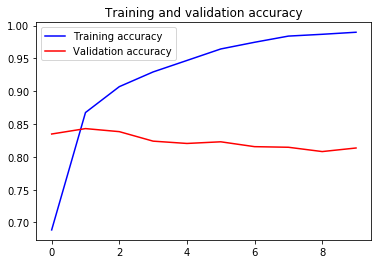

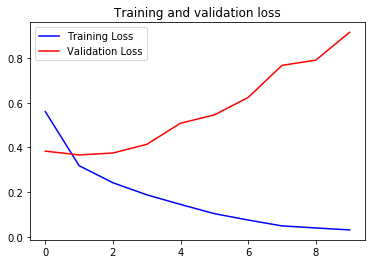

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()